![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Linear System Identification of a Damped Spring Mass Oscillator

In the following we will identify linear models for a damped spring mass oscillator under varying noise conditions.<br>
<img src="./img/mass_oscillator.png" alt="mass oscillator" width="500" />

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Parametrize System

$\dot{x} = A x + B u$

$y = C x + D u $

$\left[\begin{array}{c}\dot{s} \\ \ddot{s}\end{array}\right]=\left[\begin{array}{cc}0 & 1 \\ -\frac{c}{m} & -\frac{k}{m}\end{array}\right]\left[\begin{array}{l}s \\ \dot{s}\end{array}\right]+\left[\begin{array}{c}0 \\ \frac{1}{m}\end{array}\right] F$



$\left[\begin{array}{c}\hat{s} \\ \hat{\dot{s}} \end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right]\left[\begin{array}{l}s \\ \dot{s}\end{array}\right]+\left[\begin{array}{c}0 \\ 0 \end{array}\right] F$

In [2]:
m = 2
c = 50
k = 0.5
dt = 0.01

A_cont = np.array([[0, 1], [-c/m, -k/m]])
B_cont = np.array([[0], [1/m]])
C_cont = np.eye(2)
D_cont = np.zeros((2, 1))

## Discretize System

$x_{t+1} = A_d x_t + B_d u_t$

$y_t = C_d x_t + D_d u_t$

In [3]:
sys_cont = ct.StateSpace(A_cont, B_cont, C_cont, D_cont)
sys_dis = sys_cont.sample(dt)

A_dis = sys_dis.A
B_dis = sys_dis.B
C_dis = sys_dis.C
D_dis = sys_dis.D

## Simulate System without and with Noise

$x_{t+1} = A_d x_t + B_d u_t + w_t \quad w_t \sim \mathcal{N}(0, R)$

$y_t = C_d x_t + D_d u_t+ v_t \quad v_t \sim \mathcal{N}(0, Q)$

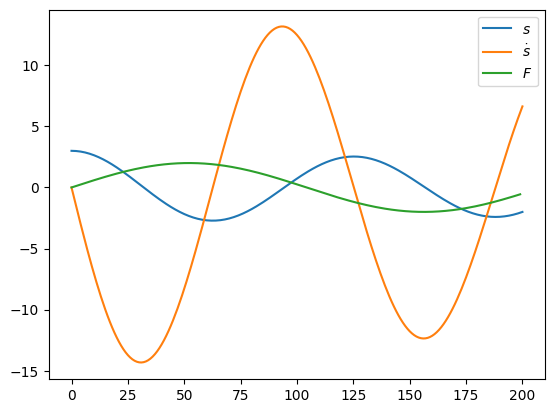

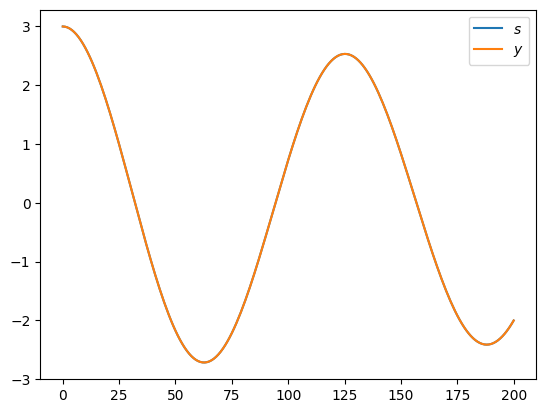

In [4]:
t_max = 2 #Simulation duration

x_0 = np.array([3, 0]) #Initial Deterministic State

Q_dis = 0.0 * np.eye(2) # Measurement Noise
R_dis = 0.0 * np.eye(2) # Process Noise

t = np.linspace(0, t_max, int(t_max/dt))
F = np.expand_dims(2*np.sin(3*t), axis=0)
x_arr = np.zeros((A_dis.shape[1], t.shape[0]+1))
y_arr = np.zeros((C_dis.shape[1], t.shape[0]+1))
u_arr = np.zeros((B_dis.shape[1], t.shape[0]))

x_arr[:, 0] = x_0 + np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis) #Initial Noisy State
y_arr[:, 0] = np.matmul(C_dis, x_arr[:, 0]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis) #Initial Noisy Measurement

for i in range(t.shape[0]):
    x_arr[:, i+1] = np.matmul(A_dis, x_arr[:, i]+ np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis)) + np.matmul(B_dis, F[:, i])
    y_arr[:, i+1] = np.matmul(C_dis, x_arr[:, i+1]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis)
    u_arr[:, i] = F[:, i]

plt.plot(x_arr[0, :], label='$s$')
plt.plot(x_arr[1, :], label='$\dot{s}$')
plt.plot(u_arr[0, :], label='$F$')
plt.legend()
plt.show()

plt.plot(x_arr[0, :], label='$s$')
plt.plot(y_arr[0, :], label='$y$')
plt.legend()
plt.show()

## Identify System

In [5]:
H = np.concatenate((y_arr[:, :t.shape[0]], u_arr), axis=0)
y = y_arr[:, 1:]

AB = np.matmul(y, np.matmul(np.transpose(H, (1, 0)), np.linalg.inv(np.matmul(H, np.transpose(H, (1, 0))))))

A_dis_id = AB[:, :2]
B_dis_id = AB[:, 2:3]

print('True System Matrix:')
print(A_dis)
print('Identified System Matrix:')
print(A_dis_id)
print('Identification Error:')
print(np.abs(A_dis_id - A_dis))
print('True Input Matrix:')
print(A_dis)
print('Identified Input Matrix:')
print(B_dis_id)
print('Identification Error:')
print(np.abs(B_dis_id - B_dis))

True System Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified System Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identification Error:
[[2.22044605e-16 1.73472348e-17]
 [5.27355937e-16 3.33066907e-16]]
True Input Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified Input Matrix:
[[2.49739770e-05]
 [4.99167473e-03]]
Identification Error:
[[3.47784952e-16]
 [5.27355937e-16]]


## Add Measurement Noise

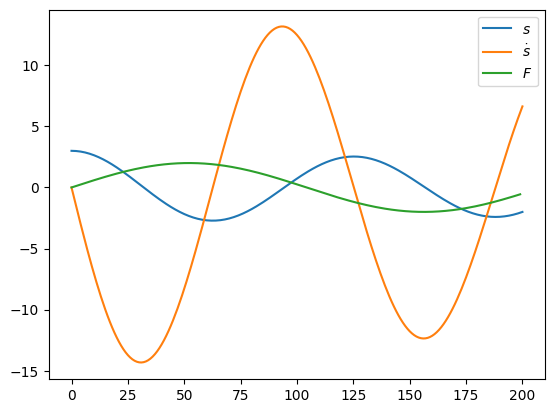

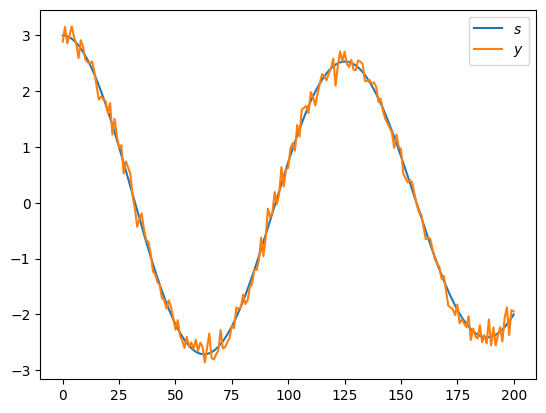

True System Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified System Matrix:
[[ 0.99286605  0.00998017]
 [-0.24801634  0.99603797]]
Identification Error:
[[5.88525423e-03 3.18136890e-06]
 [1.56739379e-03 2.17498165e-04]]
True Input Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified Input Matrix:
[[-0.00228285]
 [ 0.00794822]]
Identification Error:
[[0.00230783]
 [0.00295654]]


In [6]:
t_max = 2

x_0 = np.array([3, 0])

Q_dis = 0.02 * np.eye(2) # Measurement Noise
R_dis = 0.0 * np.eye(2) # Process Noise

t = np.linspace(0, t_max, int(t_max/dt))
F = np.expand_dims(2*np.sin(3*t), axis=0)
x_arr = np.zeros((A_dis.shape[1], t.shape[0]+1))
y_arr = np.zeros((C_dis.shape[1], t.shape[0]+1))
u_arr = np.zeros((B_dis.shape[1], t.shape[0]))

x_arr[:, 0] = x_0 + np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis)
y_arr[:, 0] = np.matmul(C_dis, x_arr[:, 0]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis)

for i in range(t.shape[0]):
    x_arr[:, i+1] = np.matmul(A_dis, x_arr[:, i]+ np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis)) + np.matmul(B_dis, F[:, i])
    y_arr[:, i+1] = np.matmul(C_dis, x_arr[:, i+1]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis)
    u_arr[:, i] = F[:, i]

plt.plot(x_arr[0, :], label='$s$')
plt.plot(x_arr[1, :], label='$\dot{s}$')
plt.plot(u_arr[0, :], label='$F$')
plt.legend()
plt.show()

plt.plot(x_arr[0, :], label='$s$')
plt.plot(y_arr[0, :], label='$y$')
plt.legend()
plt.show()

H = np.concatenate((y_arr[:, :t.shape[0]], u_arr), axis=0)
y = y_arr[:, 1:]

AB = np.matmul(y, np.matmul(np.transpose(H, (1, 0)), np.linalg.inv(np.matmul(H, np.transpose(H, (1, 0))))))

A_dis_id = AB[:, :2]
B_dis_id = AB[:, 2:3]

print('True System Matrix:')
print(A_dis)
print('Identified System Matrix:')
print(A_dis_id)
print('Identification Error:')
print(np.abs(A_dis_id - A_dis))
print('True Input Matrix:')
print(A_dis)
print('Identified Input Matrix:')
print(B_dis_id)
print('Identification Error:')
print(np.abs(B_dis_id - B_dis))

## Add Process Noise

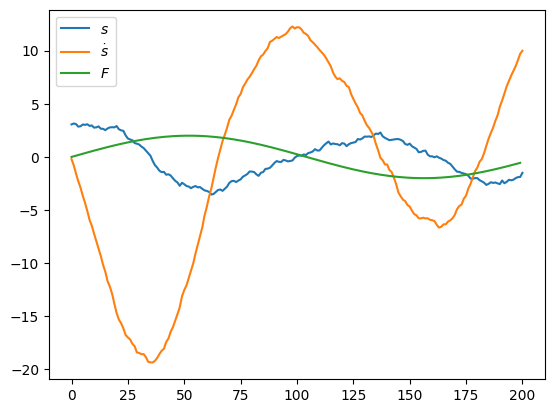

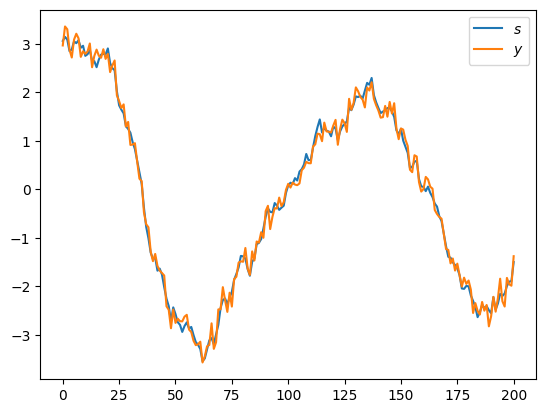

True System Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified System Matrix:
[[ 0.99426261  0.01016072]
 [-0.25148272  0.99584924]]
Identification Error:
[[0.0044887  0.00017737]
 [0.00189898 0.00040622]]
True Input Matrix:
[[ 0.9987513   0.00998335]
 [-0.24958374  0.99625546]]
Identified Input Matrix:
[[ 0.01671306]
 [-0.00091243]]
Identification Error:
[[0.01668809]
 [0.0059041 ]]


In [7]:
t_max = 2

x_0 = np.array([3, 0])

Q_dis = 0.02 * np.eye(2) # Measurement Noise
R_dis = 0.02 * np.eye(2) # Process Noise

t = np.linspace(0, t_max, int(t_max/dt))
F = np.expand_dims(2*np.sin(3*t), axis=0)
x_arr = np.zeros((A_dis.shape[1], t.shape[0]+1))
y_arr = np.zeros((C_dis.shape[1], t.shape[0]+1))
u_arr = np.zeros((B_dis.shape[1], t.shape[0]))

x_arr[:, 0] = x_0 + np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis)
y_arr[:, 0] = np.matmul(C_dis, x_arr[:, 0]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis)

for i in range(t.shape[0]):
    x_arr[:, i+1] = np.matmul(A_dis, x_arr[:, i]+ np.random.multivariate_normal(mean=np.zeros(R_dis.shape[0]), cov=R_dis)) + np.matmul(B_dis, F[:, i])
    y_arr[:, i+1] = np.matmul(C_dis, x_arr[:, i+1]) + np.random.multivariate_normal(mean=np.zeros(Q_dis.shape[0]), cov=Q_dis)
    u_arr[:, i] = F[:, i]

plt.plot(x_arr[0, :], label='$s$')
plt.plot(x_arr[1, :], label='$\dot{s}$')
plt.plot(u_arr[0, :], label='$F$')
plt.legend()
plt.show()

plt.plot(x_arr[0, :], label='$s$')
plt.plot(y_arr[0, :], label='$y$')
plt.legend()
plt.show()

H = np.concatenate((y_arr[:, :t.shape[0]], u_arr), axis=0)
y = y_arr[:, 1:]

AB = np.matmul(y, np.matmul(np.transpose(H, (1, 0)), np.linalg.inv(np.matmul(H, np.transpose(H, (1, 0))))))

A_dis_id = AB[:, :2]
B_dis_id = AB[:, 2:3]

print('True System Matrix:')
print(A_dis)
print('Identified System Matrix:')
print(A_dis_id)
print('Identification Error:')
print(np.abs(A_dis_id - A_dis))
print('True Input Matrix:')
print(A_dis)
print('Identified Input Matrix:')
print(B_dis_id)
print('Identification Error:')
print(np.abs(B_dis_id - B_dis))